In [1]:
import torch
import random
from monai.networks.nets import UNet
from monai.losses import DiceCELoss, DiceLoss
from monai.data import Dataset
from monai.transforms import Compose,ToTensord, LoadImaged, EnsureChannelFirstD, Rotate90d, Flipd, ToDeviced

In [2]:
class FloodAreaSegmentation(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.lenght = len(data)
        self.transform = transform

    def __len__(self):
        return self.lenght

    def __getitem__(self, index):       
        return {'image': self.data[index]["image"] , 'label': self.data[index]["label"]}

In [3]:
class DataLoader() :
    def __init__(self, dataset, batch_size=5, shuffle=True, transform = None, sides_size = 512, device = torch.device("cpu")) :
        self.dataset = dataset
        self.batch_size = batch_size
        self.transform = transform
        self.size = sides_size
        self.shuffle = True
        self.device = device
    
    def __iter__(self):
        self.aviable_indexes = list(range(self.dataset.lenght))
        return self        

    def __next__(self):
        actual_batch_size = self.batch_size if len(self.aviable_indexes) >= self.batch_size else len(self.aviable_indexes)
        if actual_batch_size <= 0 :
            raise StopIteration() 
        if self.shuffle :
            sampled_elements = random.sample(self.aviable_indexes, actual_batch_size)
        else :
            sampled_elements = self.aviable_indexes[:actual_batch_size]
        
        batch_images = torch.zeros((actual_batch_size,3,self.size,self.size)).to(self.device)
        batch_labels = torch.zeros((actual_batch_size,1,self.size,self.size)).to(self.device)
        batch = {}
        batch["image"] = batch_images
        batch["label"] = batch_labels
        for i,element in enumerate(sampled_elements):                
            to_select = self.aviable_indexes.index(element)
            transformed =  self.transform({"image" : self.dataset[to_select]["image"],"label" :self.dataset[to_select]["label"]})
            batch["image"][i] = transformed["image"]     
            batch["label"][i] = transformed["label"]
            batch["label"][i]  = torch.where(batch["label"][i] == 255, 1,0)
            self.aviable_indexes.remove(element)
        
        batch = self.discard_empties(batch)
        return batch
    
    def discard_empties(self,batch : torch.Tensor):
        non_zero_indices = torch.argwhere(batch["label"].sum(dim=(1,2,3)) != 0)        
        batch_images = batch["image"][non_zero_indices.T[0]] 
        batch_labels = batch["label"][non_zero_indices.T[0]] 
        batch = {}
        batch["image"] = batch_images
        batch["label"] = batch_labels

        return batch
        

        

In [4]:
images_path, labels_path = tuple([f"C:/Users/Admin/Desktop/Flood Area Segmentation/Dataset/Train/{x}" for x in ["Images","Labels"]])

train_set = {num : {
    "image" : f"{images_path}/{num}.png",
    "label" : f"{labels_path}/{num}.png"   
} for num in range(0,699)}

images_path, labels_path = tuple([f"C:/Users/Admin/Desktop/Flood Area Segmentation/Dataset/Test/{x}" for x in ["Images","Labels"]])

test_set = {num - 700 : {
    "image" : f"{images_path}/{num}.png",
    "label" : f"{labels_path}/{num}.png"   
} for num in range(700,1045)}


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

using cuda


In [6]:
model = UNet(
spatial_dims=2, 
in_channels=3, 
out_channels=1,
channels=(16,32,64,128,256,512),
strides=(2,2,2,2,2),
    num_res_units=4).to(device)

# model.load_state_dict(torch.load('unet_model_monai_dice.pth'))



<All keys matched successfully>

In [7]:
train_transforms = Compose([
    LoadImaged(keys=['image','label']),
    ToTensord(keys=['image','label']),
    ToDeviced(keys=['image','label'],device=device),
    EnsureChannelFirstD(keys=['image','label']),
    Rotate90d(keys=['image','label'], k=3),
    Flipd(keys=['image','label'], spatial_axis=1),
])


In [8]:
dataset_train = FloodAreaSegmentation(train_set, transform=train_transforms)
dataloader_train = DataLoader(dataset_train, batch_size=5, shuffle=True, transform=train_transforms)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [10]:
def dicemetric(y_pred,y,sigmoid = True) :
    if sigmoid : y_pred = torch.sigmoid(y_pred)
    overlap = torch.where(y_pred == y,1,0)
    true_positives = torch.count_nonzero(torch.where(y == 1, overlap, 0))
    false_negatives = torch.count_nonzero(torch.where(y == 1, 1 - overlap, 0))
    false_positive = torch.count_nonzero(torch.where(y==0, 1 - overlap, 0))
    return 2*true_positives/(false_negatives+false_positive + 2*true_positives)
    
metrics = [
    {"name" : "dice", "function" : dicemetric}
]

In [11]:
def trainloop(model,criterion,dataloader,quiet = False, flush_memory=False) :
    model.train()    
    epoch_loss = 0
    step = 0
    for batch in dataloader:
        step += 1

        inputs, targets = batch['image'].to(device), batch['label'].to(device)        
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()        
        if(not quiet) : print("CE:{}".format(loss.item()))  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
    if flush_memory : torch.cuda.empty_cache()

    return epoch_loss/step

In [12]:
def test(model, metrics, dataloader : DataLoader, quiet = True) :    
    model.eval()
    epoch_loss = 0
    step = 0    
    for batch in dataloader :    
        step +=1
        inputs, targets = batch['image'].to(device), batch['label'].to(device)
        outputs = model(inputs)   
        for metric in metrics :            
            metric_name = metric["name"]
            criterion = metric["function"]
            loss = criterion(outputs, targets)
            if(not quiet) : print(f"{metric_name} : {loss.item()}")
            epoch_loss += loss.item()

    metric_scores = []
    for metric in metrics :
        metric_name = metric["name"]
        if(not quiet) : print(f"Final-{metric_name} : {epoch_loss/step}")
        metric_scores.append({"name": metric_name, "score" : epoch_loss/step})

    return metric_scores

In [13]:
num_epochs = 1
criterion = DiceLoss(sigmoid=True).to(device)
train_losses = []
test_metrics = []
     
for epoch in range(num_epochs):   
    loss = trainloop(model,criterion,dataloader_train)
    train_losses.append(loss)
    torch.cuda.empty_cache()
    scores = test(model,metrics,dataloader_train)
    test_metrics.append(scores)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}')
    for score in scores :
        print(f'Epoch {epoch+1}/{num_epochs}, {score["name"]} : {score["score"]}')

torch.save(model.state_dict(), 'unet_model_monai_dice.pth')

CE:0.48948416113853455
CE:0.2774893343448639
CE:0.618746817111969
CE:0.5770705938339233
CE:0.4488241672515869
CE:0.3466147184371948
CE:0.44396334886550903
CE:0.4789876341819763
CE:0.4223976135253906
CE:0.40422677993774414
CE:0.4455207586288452
CE:0.5326718688011169
CE:0.6983230710029602
CE:0.4799942672252655
CE:0.47009173035621643
CE:0.399391770362854
CE:0.250326931476593
CE:0.24388623237609863
CE:0.3102693259716034
CE:0.5552387237548828
CE:0.4809441566467285
CE:0.44521698355674744
CE:0.6563658714294434
CE:0.42776042222976685
CE:0.26290684938430786
CE:0.3589456379413605
CE:0.39174970984458923
CE:0.364631712436676
CE:0.43080946803092957
CE:0.5512105822563171
CE:0.5803543925285339
CE:0.5070000886917114
CE:0.4294833838939667
CE:0.697698175907135
CE:0.27984169125556946
CE:0.4015505313873291
CE:0.3887735903263092
CE:0.47281724214553833
CE:0.43814384937286377
CE:0.4188421070575714
CE:0.2952583134174347
CE:0.4434904456138611
CE:0.5068747997283936
CE:0.31083226203918457
CE:0.5906236171722412
C

In [ ]:
from matplotlib import pyplot as plt
def display_segmentation(model,dataset : FloodAreaSegmentation,id) :
    input_dict = dataset.transform(dataset[id])    
    model.eval()
    img = torch.unsqueeze(input_dict["image"],dim=0)
    print(img.shape)
    img_r = img[0,0,:,:]
    img_g = img[0,1,:,:]
    img_b = img[0,2,:,:]
    img_rgb = torch.stack([img_r,img_g,img_b],dim=2).to(torch.int32)    

    output = model(img)
    out_treshold = torch.where(output>0,1,0)
    # out_treshold = torch.sigmoid(output)

    lab = (input_dict["label"][0,:,:].cpu()).to(torch.int32)

    plt.subplot(1,3,1)
    plt.imshow(lab)
    plt.subplot(1,3,2)
    plt.imshow(img_rgb.detach().cpu())
    plt.subplot(1,3,3)   
    plt.imshow(out_treshold.detach().cpu()[0,0,:,:])

In [ ]:
dataset_test = FloodAreaSegmentation(test_set,transform=train_transforms)
dataloader_test = DataLoader(dataset_test,25,transform=train_transforms,sides_size=512)

torch.Size([1, 3, 512, 512])


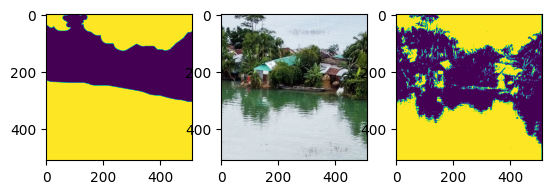

In [ ]:
display_segmentation(model,dataset_test,8)

In [ ]:
test(model,metrics,dataloader_test)

tensor([[[[ 1.3551,  5.3084,  1.5529,  ...,  1.9967,  1.2153, -0.5730],
          [ 6.7241,  0.5132,  1.7840,  ...,  3.2526,  0.7147, -0.1472],
          [ 2.6800,  6.1642,  2.3447,  ...,  2.9622,  2.1361, -0.6271],
          ...,
          [ 0.2068, -0.8721, -0.9583,  ...,  1.2501,  0.3977, -0.9586],
          [-0.7784, -0.6687, -0.9357,  ...,  1.0466,  0.0215, -0.5886],
          [-0.0434, -0.5191, -0.6295,  ...,  0.5443,  0.0610, -0.7204]]],


        [[[ 0.0783,  2.3858, -0.1103,  ..., -0.2127, -0.5649, -1.4329],
          [ 3.9012, -0.7712, -0.1726,  ...,  1.0773, -0.7969, -1.0779],
          [ 1.0886,  3.3564,  0.1649,  ...,  0.4574, -0.2277, -1.5125],
          ...,
          [ 1.8362, -1.0539, -1.4514,  ..., -0.7452, -1.2754, -1.6804],
          [-1.6029, -0.7322, -1.3727,  ..., -0.9620, -1.5370, -1.4157],
          [ 0.0409, -0.7803, -1.0022,  ..., -0.3844, -0.8963, -1.3183]]],


        [[[ 1.6270,  5.7501,  2.2660,  ...,  2.3871,  1.5969, -0.3142],
          [ 7.2508,  1.097

KeyboardInterrupt: 

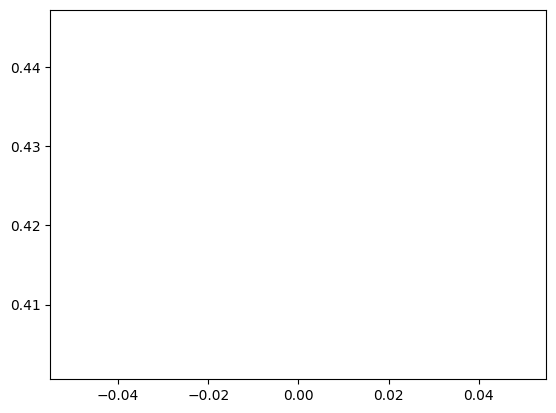

In [ ]:
# plt.plot([m[0]["score"] for m in test_metrics])
plt.plot(train_losses)